In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os, psutil, time
from scipy import linalg as la
from ssidid.SSID_Hankel_loss import run_bad, plot_slim, print_slim, f_l2_Hankel_nl, f_l2_Hankel_comp_Q_Om
from ssidid.utility import get_subpop_stats, gen_data
from ssidid import ObservationScheme
from subtracking import Grouse, calc_subspace_proj_error
import py4sid

#np.random.seed(0)

# define problem size
p, n, T = 1000, 10, 1000
lag_range = np.arange(10)

# I/O matter
mmap, chunksize = True, np.min((p,10000))
data_path, save_file = '/home/marcel/Desktop/Projects/Stitching/code/le_stitch/python/fits/', 'test'
verbose=True

# create subpopulations
obs_scheme = ObservationScheme(p=p,T=T,
                               sub_pops=(np.arange(p),), 
                               obs_pops=(0,),
                               obs_time=(T,))

# draw system matrices 
print('(p,n,T) = ', (p,n,T), '\n')
nr = 2 # number of real eigenvalues
eig_m_r, eig_M_r, eig_m_c, eig_M_c = 0.8, 0.99, 0.8, 0.99
pars_true, x, y, _, _ = gen_data(p,n,lag_range,T, nr,
                                             eig_m_r, eig_M_r, 
                                             eig_m_c, eig_M_c,
                                             mmap, chunksize,
                                             data_path)
pars_est='default'

idx_a = np.sort(np.random.choice(p, np.minimum(p,1000), replace=False))
idx_b = idx_a.copy()

W = obs_scheme.comp_coocurrence_weights(lag_range, sso=True, idx_a=idx_a, idx_b=idx_b)
print('computing time-lagged covariances')
Qs, Om = f_l2_Hankel_comp_Q_Om(n=n,y=y,lag_range=lag_range,obs_scheme=obs_scheme,
                      idx_a=idx_a,idx_b=idx_b,W=W,sso=True,
                      mmap=mmap,data_path=data_path,ts=None,ms=None)

(p,n,T) =  (1000, 10, 1000) 

ObservationScheme warning: ignoring arguments idx_a,idx_b if sso=True
computing time-lagged covariances


In [2]:
kl_ = np.max(lag_range)+1
A, C = py4sid.estimate_parameters_moments(y,kl_,n)

entering estimate_parameters_moments...
...done in 296.313 seconds!


In [20]:
kl_ = np.max(lag_range)+1
A, C = py4sid.estimate_parameters_moments(y,2*n,n)

entering estimate_parameters_moments...
...done in 2100.887 seconds!


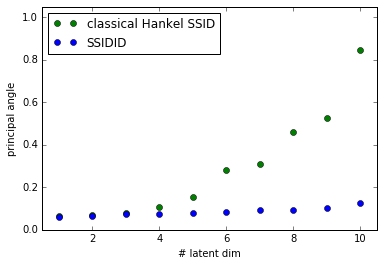

In [21]:

plt.plot(np.arange(1, n+1), principal_angle(pars_true['C'], C), 'go') 
plt.plot(np.arange(1, n+1), principal_angle(pars_true['C'], pars_est['C']), 'bo')
plt.legend(('classical Hankel SSID', 'SSIDID'), loc=2)
plt.xlabel('# latent dim')
plt.ylabel('principal angle')
plt.axis([0.5, n+0.5, 0, 1.05])
plt.show()

starting descent


/home/marcel/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:2151: RuntimeWarning: invalid value encountered in true_divide
  return c / sqrt(multiply.outer(d, d))


finished % 10.0
finished % 20.0
finished % 30.0
finished % 40.0
finished % 50.0
finished % 60.0
finished % 70.0
finished % 80.0
finished % 90.0
finished % 100.0
total iterations:  19800
m = 0, corr = 0.848248122482
m = 1, corr = 0.853391757277
m = 2, corr = 0.855020728785
m = 3, corr = 0.861700634349
m = 4, corr = 0.789784699172
m = 5, corr = 0.860606946295
m = 6, corr = 0.843989700938
m = 7, corr = 0.851502492716
m = 8, corr = 0.839171321064
m = 9, corr = 0.851126310744
fitting time was  32.92602896690369 s
rank of final C_est:  10


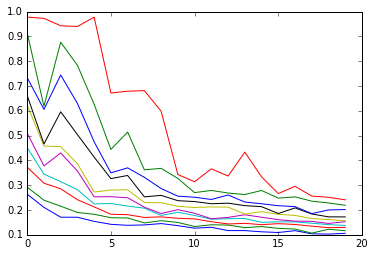

In [4]:
from scipy import linalg as la

parametrization='nl'
sso = True

# settings for quick initial SGD fitting phase for our model
batch_size, max_zip_size, max_iter = 1, np.inf, 20
a, b1, b2, e = 0.01, 0.98, 0.99, 1e-8
a_decay = 0.98
a_R = 1 * a

proj_errors = np.zeros((max_iter,n+1))
def principal_angle(A, B):
    "A and B must be column-orthogonal."    
    A = np.atleast_2d(A).T if (A.ndim<2) else A
    B = np.atleast_2d(B).T if (B.ndim<2) else B
    A = la.orth(A)
    B = la.orth(B)
    svd = la.svd(A.T.dot(B))
    return np.arccos(np.minimum(svd[1], 1.0)) / (np.pi/2)
    
def pars_track(pars,t): 
    C = pars[0]
    proj_errors[t] = np.hstack((0, principal_angle(pars_true['C'], C)))
            
_, pars_est, traces, Qs, Om, W, t = run_bad(lag_range=lag_range,n=n,y=y, idx_a=idx_a, idx_b=idx_b,
                                      obs_scheme=obs_scheme,init=pars_est,
                                      parametrization=parametrization, sso=sso,
                                      Qs=Qs, Om=Om, W=W, 
                                      alpha=a,b1=b1,b2=b2,e=e,max_iter=max_iter,a_decay=a_decay,
                                      batch_size=batch_size,verbose=True, max_epoch_size=max_zip_size,
                                      pars_track=pars_track,save_every=np.inf, data_path=data_path)

print_slim(Qs,Om,lag_range,pars_est,idx_a,idx_b,traces,False,data_path)
print('fitting time was ', t, 's')
print('rank of final C_est: ', sp.linalg.orth(pars_est['C']).shape[1])

plt.plot(proj_errors[:,1:])
plt.show()


starting descent
finished % 10.0
finished % 20.0
finished % 30.0
finished % 40.0
finished % 50.0
finished % 60.0
finished % 70.0
finished % 80.0
finished % 90.0
finished % 100.0
total iterations:  1980
m = 0, corr = 0.986722073737
m = 1, corr = 0.983089223239
m = 2, corr = 0.982062068069
m = 3, corr = 0.977906449493
m = 4, corr = 0.976481436369
m = 5, corr = 0.975911127046
m = 6, corr = 0.971451650153
m = 7, corr = 0.972966635209
m = 8, corr = 0.969062641077
m = 9, corr = 0.967120790932
fitting time was  15.338382720947266 s
rank of final C_est:  10


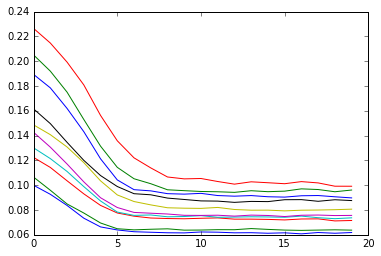

In [6]:
batch_size, max_zip_size, max_iter = 10, np.inf, 20
a, b1, b2, e = 0.005, 0.9, 0.99, 1e-8
a_decay = 0.98
a_R = 1 * a

def pars_track(pars,t): 
    C = pars[0]
    proj_errors[t] = np.hstack((0, principal_angle(pars_true['C'], C)))
            
_, pars_est, traces, Qs, Om, W, t = run_bad(lag_range=lag_range,n=n,y=y, idx_a=idx_a, idx_b=idx_b,
                                      obs_scheme=obs_scheme,init=pars_est,
                                      parametrization=parametrization, sso=sso,
                                      Qs=Qs, Om=Om, W=W, 
                                      alpha=a,b1=b1,b2=b2,e=e,max_iter=max_iter,a_decay=a_decay,
                                      batch_size=batch_size,verbose=True, max_epoch_size=max_zip_size,
                                      pars_track=pars_track,save_every=np.inf, data_path=data_path)

print_slim(Qs,Om,lag_range,pars_est,idx_a,idx_b,traces,False,data_path)
print('fitting time was ', t, 's')
print('rank of final C_est: ', sp.linalg.orth(pars_est['C']).shape[1])

plt.plot(proj_errors[:,1:])
plt.show()


In [7]:

principal_angle(pars_true['C'], C),  principal_angle(pars_true['C'], pars_est['C'])

(array([ 0.06272945,  0.06778386,  0.07645892,  0.08005616,  0.09235705,
         0.1585976 ,  0.21063336,  0.41629499,  0.82227527,  0.9939225 ]),
 array([ 0.06183947,  0.06375493,  0.07154046,  0.07368625,  0.07564272,
         0.08067273,  0.08760968,  0.0897602 ,  0.09609854,  0.09916047]))

In [8]:
pars_est = 'default'
lag_range = np.arange(1,11)

starting descent


/home/marcel/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:2151: RuntimeWarning: invalid value encountered in true_divide
  return c / sqrt(multiply.outer(d, d))


finished % 10.0
finished % 20.0
finished % 30.0
finished % 40.0
finished % 50.0
finished % 60.0
finished % 70.0
finished % 80.0
finished % 90.0
finished % 100.0
total iterations:  19780
m = 1, corr = 0.800881651864
m = 2, corr = 0.804821494881
m = 3, corr = 0.818558499499
m = 4, corr = 0.801926996167
m = 5, corr = 0.834879372267
m = 6, corr = 0.84947171357
m = 7, corr = 0.838911388575
m = 8, corr = 0.843048654036
m = 9, corr = 0.833535725292
m = 10, corr = 0.83873549593
fitting time was  24.945903778076172 s
rank of final C_est:  10


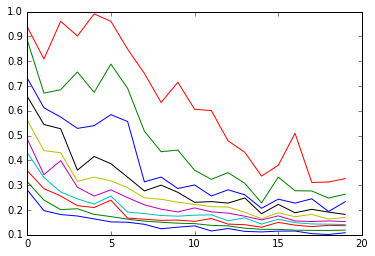

In [9]:
from scipy import linalg as la

parametrization='nl'
sso = True

# settings for quick initial SGD fitting phase for our model
batch_size, max_zip_size, max_iter = 1, np.inf, 20
a, b1, b2, e = 0.01, 0.98, 0.99, 1e-8
a_decay = 0.98
a_R = 1 * a

proj_errors = np.zeros((max_iter,n+1))
def principal_angle(A, B):
    "A and B must be column-orthogonal."    
    A = np.atleast_2d(A).T if (A.ndim<2) else A
    B = np.atleast_2d(B).T if (B.ndim<2) else B
    A = la.orth(A)
    B = la.orth(B)
    svd = la.svd(A.T.dot(B))
    return np.arccos(np.minimum(svd[1], 1.0)) / (np.pi/2)
    
def pars_track(pars,t): 
    C = pars[0]
    proj_errors[t] = np.hstack((0, principal_angle(pars_true['C'], C)))
            
_, pars_est, traces, Qs, Om, W, t = run_bad(lag_range=lag_range,n=n,y=y, idx_a=idx_a, idx_b=idx_b,
                                      obs_scheme=obs_scheme,init=pars_est,
                                      parametrization=parametrization, sso=sso,
                                      Qs=Qs, Om=Om, W=W, 
                                      alpha=a,b1=b1,b2=b2,e=e,max_iter=max_iter,a_decay=a_decay,
                                      batch_size=batch_size,verbose=True, max_epoch_size=max_zip_size,
                                      pars_track=pars_track,save_every=np.inf, data_path=data_path)

print_slim(Qs,Om,lag_range,pars_est,idx_a,idx_b,traces,False,data_path)
print('fitting time was ', t, 's')
print('rank of final C_est: ', sp.linalg.orth(pars_est['C']).shape[1])

plt.plot(proj_errors[:,1:])
plt.show()


starting descent
finished % 10.0
finished % 20.0
finished % 30.0
finished % 40.0
finished % 50.0
finished % 60.0
finished % 70.0
finished % 80.0
finished % 90.0
finished % 100.0
total iterations:  1960
m = 1, corr = 0.934141246235
m = 2, corr = 0.954643042838
m = 3, corr = 0.960025086549
m = 4, corr = 0.960616382843
m = 5, corr = 0.969097887071
m = 6, corr = 0.965247330588
m = 7, corr = 0.96378592164
m = 8, corr = 0.964160495576
m = 9, corr = 0.962669704371
m = 10, corr = 0.958360521642
fitting time was  18.53862166404724 s
rank of final C_est:  10


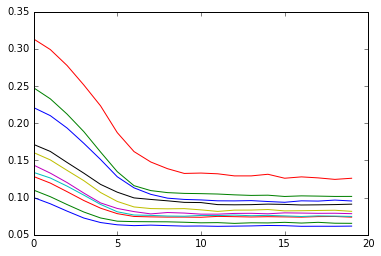

In [13]:
batch_size, max_zip_size, max_iter = 10, np.inf, 20
a, b1, b2, e = 0.005, 0.9, 0.99, 1e-8
a_decay = 0.98
a_R = 1 * a

def pars_track(pars,t): 
    C = pars[0]
    proj_errors[t] = np.hstack((0, principal_angle(pars_true['C'], C)))
            
_, pars_est, traces, Qs, Om, W, t = run_bad(lag_range=lag_range,n=n,y=y, idx_a=idx_a, idx_b=idx_b,
                                      obs_scheme=obs_scheme,init=pars_est,
                                      parametrization=parametrization, sso=sso,
                                      Qs=Qs, Om=Om, W=W, 
                                      alpha=a,b1=b1,b2=b2,e=e,max_iter=max_iter,a_decay=a_decay,
                                      batch_size=batch_size,verbose=True, max_epoch_size=max_zip_size,
                                      pars_track=pars_track,save_every=np.inf, data_path=data_path)

print_slim(Qs,Om,lag_range,pars_est,idx_a,idx_b,traces,False,data_path)
print('fitting time was ', t, 's')
print('rank of final C_est: ', sp.linalg.orth(pars_est['C']).shape[1])

plt.plot(proj_errors[:,1:])
plt.show()


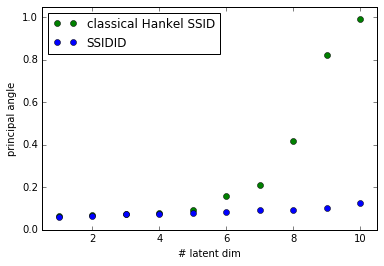

In [19]:

plt.plot(np.arange(1, n+1), principal_angle(pars_true['C'], C), 'go') 
plt.plot(np.arange(1, n+1), principal_angle(pars_true['C'], pars_est['C']), 'bo')
plt.legend(('classical Hankel SSID', 'SSIDID'), loc=2)
plt.xlabel('# latent dim')
plt.ylabel('principal angle')
plt.axis([0.5, n+0.5, 0, 1.05])
plt.show()